In [20]:
#HF Example

import torch
from transformers import pipeline

pipe = pipeline(
    task="image-classification",
    model="facebook/dinov2-small-imagenet1k-1-layer",
    dtype=torch.float16,
    device="cuda"
)

pipe("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg")

Device set to use cuda


[{'label': 'tiger, Panthera tigris', 'score': 0.24335609376430511},
 {'label': 'tiger cat', 'score': 0.24146227538585663},
 {'label': 'lynx, catamount', 'score': 0.16084855794906616},
 {'label': 'marmot', 'score': 0.043973542749881744},
 {'label': 'tabby, tabby cat', 'score': 0.03293466567993164}]

In [21]:


from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
cls_embedding = last_hidden_states[:, 0, :]



In [22]:
print(cls_embedding.size())

torch.Size([1, 768])


In [23]:
import hdf5
file=hdf5.open_HDF5("downloaded_embeddings.h5")
vectors=file["vectors"]
vectors=vectors[:] #load into a np array
labels=file["coordinates"]
labels=labels[:]
print(vectors)
print(labels)
file.close()

[[ 0.95240444  1.3240675   0.28314427 ... -0.40695077 -0.12938523
   0.65251255]
 [ 0.73756576  1.2255933   0.01971832 ... -2.2677386   0.3768237
   1.4319218 ]
 [ 0.8730782   1.568318    0.21059269 ...  1.7526027  -1.3327127
   1.7590166 ]
 ...
 [ 2.8841746  -2.7090735  -1.8563217  ...  3.5333478  -1.8200037
  -1.7979321 ]
 [ 0.7231116  -0.3009514  -2.2173426  ... -2.9620824   1.0859857
   0.02212841]
 [ 0.88997984  0.62839216 -1.7182935  ... -2.0426896   2.6787934
   1.5962486 ]]
[[38.01888  -7.86417 ]
 [42.89792  -5.537902]
 [43.729904  3.313452]
 ...
 [47.63359  12.09996 ]
 [48.365     6.681111]
 [50.73414   9.120029]]


DINO encoder: 
Mean: tensor(0.1963, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0707, device='cuda:0', grad_fn=<DivBackward0>)
Std: tensor(0.0655, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.0752, device='cuda:0', grad_fn=<SqrtBackward0>)

Bioclip (simple architechture):
Mean: tensor(0.3107, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.0632, device='cuda:0', grad_fn=<DivBackward0>)
Std: tensor(0.0844, device='cuda:0', grad_fn=<SqrtBackward0>) tensor(0.1299, device='cuda:0', grad_fn=<SqrtBackward0>)

In [26]:
#Number of occurences in Switwerland

import pandas as pd

# Replace 'data.tsv' with the path to your file
file_path = '/home/adam/source/CLIP/data_plantnet_obsevations/occurrence.txt'

# Load the TSV file
df = pd.read_csv(file_path, sep='\t', low_memory=False)

# Check the column names for country info
print(df.columns)

# Filter rows where the country is Switzerland
switzerland_data = df[df['countryCode'] == 'CH']

# Count the number of rows
num_datapoints = len(switzerland_data)

print(f"Number of datapoints in Switzerland: {num_datapoints}")

# Filter rows where the country is Switzerland
france_data = df[df['countryCode'] == 'FR']

# Count the number of rows
num_datapoints = len(france_data)

print(f"Number of datapoints in France: {num_datapoints}")


Index(['gbifID', 'accessRights', 'bibliographicCitation', 'language',
       'license', 'modified', 'publisher', 'references', 'rightsHolder',
       'type',
       ...
       'publishedByGbifRegion', 'level0Gid', 'level0Name', 'level1Gid',
       'level1Name', 'level2Gid', 'level2Name', 'level3Gid', 'level3Name',
       'iucnRedListCategory'],
      dtype='object', length=226)
Number of datapoints in Switzerland: 74963
Number of datapoints in France: 884128


densité de points en suisse: 
74963/41 285 km2=1.81

France: 884128/632 702 km2=1.39
We good

In [27]:
# Replace 'data.tsv' with the path to your file
file_path =  '/home/adam/source/CLIP/data_plantnet_obsevations/occurrence.txt'

# Load the TSV file
df = pd.read_csv(file_path, sep='\t', low_memory=False)

# Count datapoints per country
country_counts = df['countryCode'].value_counts()

# Display results
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Full column width
print(country_counts)


countryCode
FR    884128
ES    253748
DE    237009
IT    199536
GB    132793
US    125428
NL    104618
CH     74963
CZ     61113
BE     59173
AT     44565
PL     36438
CA     29717
PT     28453
RU     22644
HU     21479
SK     16528
BR     15615
GR     14699
KE     14308
SE     13236
HR     11800
TR     11083
IN     11004
IE      9793
DK      9445
NO      9042
UA      8886
RO      8085
FI      8053
SI      7181
RE      6587
AR      6290
AU      4955
BG      4680
CL      3733
MX      3678
RS      3487
CR      3089
MA      3013
DZ      2681
CO      2623
GP      2530
LU      2396
ZA      2232
EE      2055
MQ      1981
BA      1895
ID      1850
JP      1669
IL      1645
IR      1634
BY      1602
ME      1554
LV      1549
LT      1506
NC      1490
IS      1312
TH      1302
MG      1248
CG      1143
NZ      1088
CY      1075
GE       996
MT       969
DO       946
AL       825
PE       783
GF       741
UY       719
MY       712
VN       676
AD       672
CN       668
TN       656
EC       651


Section dedicated to get the proper data and fit linear model from both covariates and embeddings, to compare.

(10013, 30)
(10013, 30) (10013, 30)
AUC cov PR: 0.8060599803800079
AUC emb PR: 0.7355840243577403
AUC cov MLP: 0.8425111929337424
AUC emb MLP: 0.7907197135528283
(50 first components of PCA for embeddings, with layers 50-64-32-1)

In [1]:
import SDM_eval
import nn_classes
import torch
import importlib
import torch.nn as nn
importlib.reload(SDM_eval)
importlib.reload(nn_classes)
from geoclip import LocationEncoder

device="cuda"
data_path="embeddings_data_and_dictionaries/bioCLIP_full_dataset_embeddings.h5"
dim_fourier_encoding=512 #multiple of 4!!
dim_hidden=1024
dim_emb=512 #this one is actually shared with img embeddings

geoclip_pos_encoder = LocationEncoder() #embeds into 512
pos_encoder = geoclip_pos_encoder = nn.Sequential(
    LocationEncoder(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 512)
)

#pos_encoder= nn_classes.RFF_MLPs(original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=dim_emb,M=8,sigma_min=2,sigma_max=256, number_layers=4)
#pos_encoder=utils.RFF_MLPs( original_dim=2, fourier_dim=dim_fourier_encoding, hidden_dim=dim_hidden, output_dim=512,M=8,sigma_min=1,sigma_max=256).to(device)

model= nn_classes.DoubleNetwork_V2(pos_encoder,dim_hidden=768,dim_output=dim_emb).to(device)
model.load_state_dict(torch.load("geoclip_pos_enc_and_2_512_layers/model.pt", weights_only=True))
pos_encoder=model.pos_encoder


/home/adam/anaconda3/envs/geoclip/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/adam/anaconda3/envs/geoclip/lib/python3.12/site-packages/geoclip/model/location_encoder.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

In [11]:
import utils
importlib.reload(utils)
sims=utils.test_similarity(
        data_path, 
        model, 
        nbr_iter=1000,
        nbr_samples=4096,
        device="cuda", 
        plot_sims=True,
        sort_duplicates=True, 
        dictionary_path="embeddings_data_and_dictionaries/data_dictionary_sciName"
        )
print(sims)

Computing similarities:   0%|          | 0/100 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 19.71 GiB of which 6.00 MiB is free. Including non-PyTorch memory, this process has 19.69 GiB memory in use. Of the allocated memory 19.07 GiB is allocated by PyTorch, and 398.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [7]:
#Train models on PO data for evaluation
PR_emb, PR_cov, MLP_emb, MLP_cov, scaler_cov, scaler_emb, pca = SDM_eval.train_models(
    pos_encoder=pos_encoder,
    do_pca=False,
    n_pca_components=None,
)



getting embeddings
shape Xemb (35105, 512)
shape Xcov (35105, 13)
shape y (35105, 30)
fitting models


100%|██████████| 200/200 [00:35<00:00,  5.58it/s]


In [9]:
#Evaluate on PA data
SDM_eval.evaluate_models(
    pos_encoder, 
    scaler_cov, 
    scaler_emb, 
    PR_cov, #from fit_multi_GLM
    PR_emb, #from fit_multi_GLM
    MLP_cov, #from train_one_MLP : shape (n_samples, n_species)
    MLP_emb,  #from train_one_MLP
    pca_model=None, #to lower dim of X_test_emb.
    ) 




(10013, 30) (10013, 30)
AUC cov PR: 0.8060599803800079
AUC emb PR: 0.778447887867525
AUC cov MLP: 0.8429471852394069
AUC emb MLP: 0.7850406583634952


{'auc_cov_PR': 0.8060599803800079,
 'auc_emb_PR': 0.778447887867525,
 'auc_cov_MLP': 0.8429471852394069,
 'auc_emb_MLP': 0.7850406583634952}

Stadard results (here from high_frequency_encoding run)
(10013, 30) (10013, 30)
AUC cov PR: 0.8060599803800079
AUC emb PR: 0.732598130855661
AUC cov MLP: 0.842159886705586
AUC emb MLP: 0.783553522732476

(48831, 2)


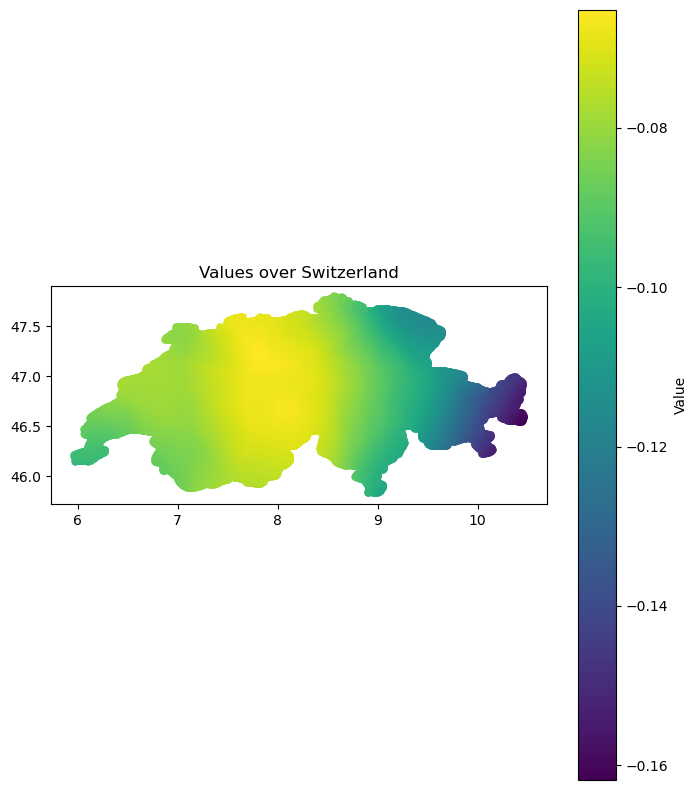

(48831, 2)


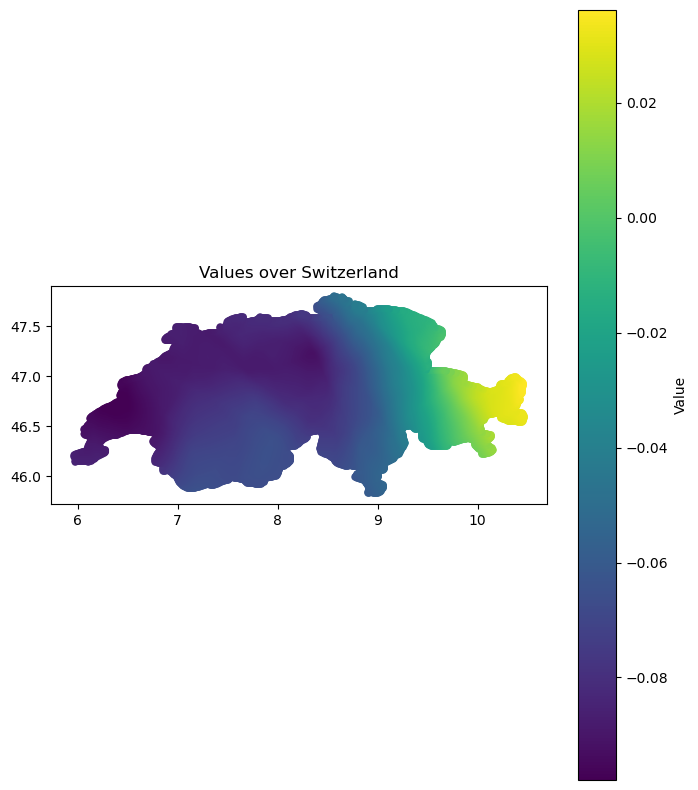

(48831, 2)


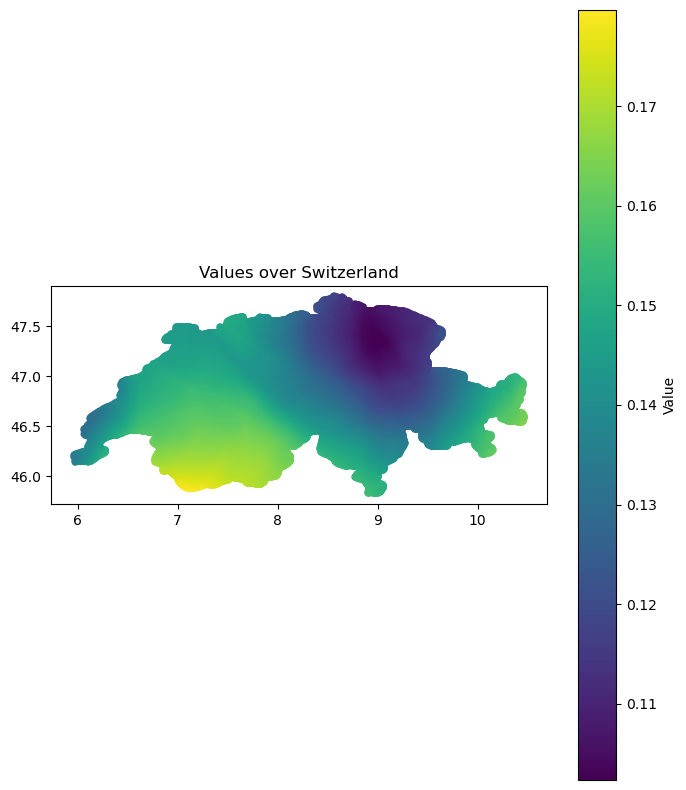

(48831, 2)


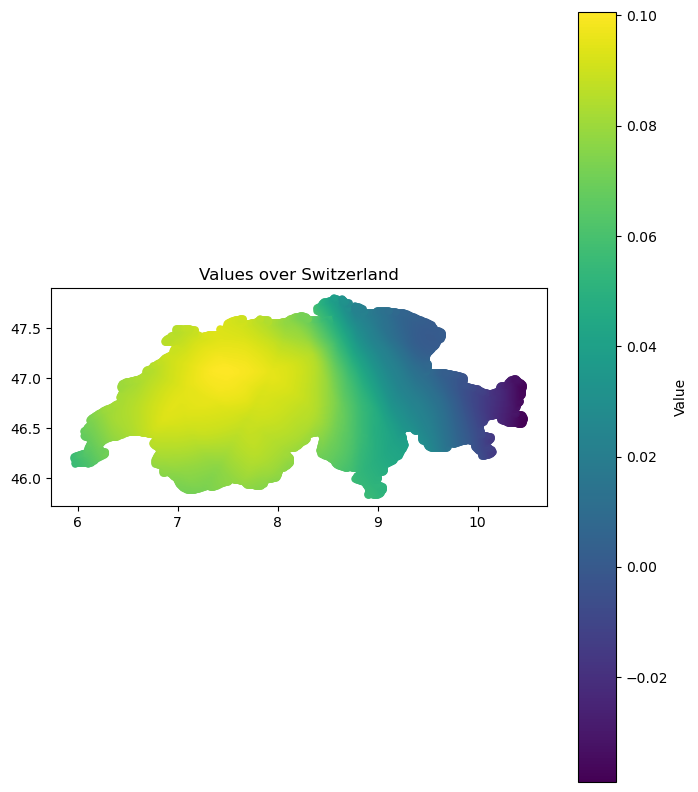

(48831, 2)


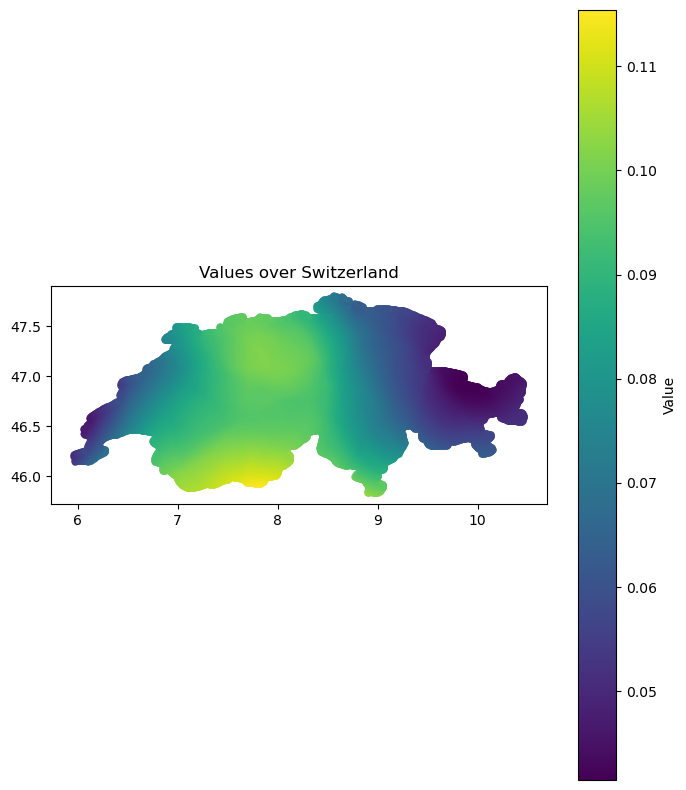

In [8]:
import utils
import importlib
importlib.reload(utils)
utils.plot_PCA("PCA_models/PCA_high_frequency_bioclip.pkl",5, model.pos_encoder)